# Import the Datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances, manhattan_distances, linear_kernel
from sklearn.feature_extraction.text import TfidfVectorizer
import os

## The Standard Dataset
This dataset will have new users removed and will be used to represent what a typical dataset would look like for a recommender system. It will be used alongside the new users dataset to build a better picture when evaluating each recommender.

The datasets aren't included in the GitHub repository due to storage restrictions with Git LFS. You can use the provided python scripts to collect the data yourself or, you can simply download the data from here: https://drive.google.com/drive/folders/1byfM21Q65Mn5gb2SVcutu_z-MspwJbr3?usp=drive_link.

In [2]:
# Data Gathered By Me Via the MyAnimeList API and Jikan REST API
anime_df = pd.read_csv('./data/anime.csv')
user_ratings_df = pd.read_csv('./data/user_ratings.csv', parse_dates=['updated_at'])

In [3]:
anime_df.head()

,id,title,start_date,end_date,synopsis,score,rank,popularity,num_list_users,num_scoring_users,media_type,status,genres,num_episodes,start_season,broadcast_day,broadcast_time,source,rating,studios
0,5114,Fullmetal Alchemist: Brotherhood,2009-04-05,2010-07-04,After a horrific alchemy experiment goes wrong...,9.10,1.0,3,3240265,2056814,tv,finished_airing,"Action,Adventure,Drama,Fantasy,Military,Shounen",64,spring,sunday,17:00,manga,r,Bones
1,9253,Steins;Gate,2011-04-06,2011-09-14,Eccentric scientist Rintarou Okabe has a never...,9.07,2.0,13,2489957,1361494,tv,finished_airing,"Drama,Psychological,Sci-Fi,Suspense,Time Travel",24,spring,wednesday,02:05,visual_novel,pg_13,White Fox
2,28977,Gintama°,2015-04-08,2016-03-30,"Gintoki, Shinpachi, and Kagura return as the f...",9.06,3.0,336,610158,243298,tv,finished_airing,"Action,Comedy,Gag Humor,Historical,Parody,Samu...",51,spring,wednesday,18:00,manga,pg_13,Bandai Namco Pictures
3,41467,Bleach: Sennen Kessen-hen,2022-10-11,2022-12-27,Substitute Soul Reaper Ichigo Kurosaki spends ...,9.05,4.0,432,489199,245969,tv,finished_airing,"Action,Adventure,Fantasy,Shounen",13,fall,tuesday,00:00,manga,r,Pierrot
4,39486,Gintama: The Final,2021-01-08,2021-01-08,Two years have passed following the Tendoshuu'...,9.05,5.0,1550,140032,67119,movie,finished_airing,"Action,Comedy,Drama,Gag Humor,Historical,Parod...",1,winter,NaN,NaN,manga,pg_13,Bandai Namco Pictures


In [4]:
user_ratings_df.head()

,user_id,anime_id,score,status,num_episodes_watched,updated_at,start_date,finish_date
0,0,41457,7,completed,11,2023-02-16 10:18:23+00:00,NaN,2023-01-01
1,0,48569,7,watching,7,2023-03-09 11:11:20+00:00,2023-01-01,NaN
2,0,32998,9,completed,12,2023-04-15 14:29:11+00:00,NaN,2023-01-01
3,0,25013,0,plan_to_watch,0,2023-04-15 14:44:38+00:00,NaN,NaN
4,0,36649,7,completed,24,2023-04-15 14:29:23+00:00,NaN,2023-01-01


## The New Users Dataset
This dataset will be intentionally biased so that it has only *new* users. This dataset will be used to evaluate each recommender's performance with new users.

The datasets aren't included in the GitHub repository due to storage restrictions with Git LFS. This dataset uses data from Kaggle, so you will need to download the dataset from here: https://drive.google.com/drive/folders/1VHbxxhSLdK_g7ro7-3a7ntgL1YXdp-WT?usp=sharing.

In [5]:
new_users_ratings_df = None

if os.path.isfile('./data/new_users_ratings.csv'): # Using this file will save time and memory
    new_users_ratings_df = pd.read_csv('./data/new_users_ratings.csv')
else:
    new_users_ratings_df = pd.read_csv('./data/rating_complete.csv')

In [6]:
new_users_ratings_df.head()

,user_id,anime_id,score
0,0,430,9
1,0,1004,5
2,0,3010,7
3,0,570,7
4,0,2762,9


In [7]:
# Keep the column headers consitent between datasets
new_users_ratings_df = new_users_ratings_df.rename(columns={"rating": "score"})

# Handle Pre-Processing

## Biasing the New Users Dataset Towards New Users
The New Users Dataset will have the same number of users as the Standard Dataset to ensure that comparing the two is fair. The New Users Dataset will have 50% of it's users be considered new.

In [8]:
print(len(new_users_ratings_df.user_id.unique()))

8738


In [9]:
if not os.path.isfile('./data/new_users_ratings.csv'): # Only need to do this if the file doesn't exist
    num_max_users = 50000
    new_users_ratings_df = new_users_ratings_df.loc[new_users_ratings_df.user_id <= num_max_users]
    
    users_to_keep = []
    target_num_users = len(user_ratings_df.user_id.unique())
    target_num_new_users = int(target_num_users * 1.0)
    target_num_std_users = target_num_users - target_num_new_users
    num_max_new_user_ratings = 30

    for user_id in new_users_ratings_df.user_id.unique():
        if len(users_to_keep) < target_num_users: # The dataset contains enough users
            users_ratings = new_users_ratings_df.loc[new_users_ratings_df.user_id == user_id]

            if len(new_users_ratings_df.loc[new_users_ratings_df.score > 0]) == 0: # Don't add user if they have only given scores of zero
                continue
            else:
                if len(users_ratings) > num_max_new_user_ratings: # Only add standard users when over the required new user threshold
                    users_to_keep.append(user_id)
                else:    
                    if len(users_to_keep) < target_num_new_users: # Only add new users when under the required threshold
                        if len(users_ratings) <= num_max_new_user_ratings and len(users_ratings) >= 2:
                            users_to_keep.append(user_id)                
        else:
            break
    
    print(f"{len(users_to_keep)}/{target_num_users}")
    new_users_ratings_df = new_users_ratings_df.loc[new_users_ratings_df.user_id.isin(users_to_keep)]
    new_users_ratings_df.to_csv('./data/new_users_ratings.csv', index=False)

## Misc Pre-Processing

In [10]:
# Only this dataset contains these columns
user_ratings_df.drop(columns=['start_date', 'finish_date'], inplace=True)

In [11]:
user_ratings_df.isna().sum()

user_id                 0
anime_id                0
score                   0
status                  1
num_episodes_watched    0
updated_at              0
dtype: int64

In [12]:
new_users_ratings_df.isna().sum()

user_id     0
anime_id    0
score       0
dtype: int64

Although the above functions shows that there are no missing score values, a score of 0 indicates that the score was missing since it's not possible on MyAnimeList to rate an anime 0 unless you choose not to rate the anime.

## Remove Users who have only given scores of 0 in the Standard Dataset

In [13]:
def remove_zero_scoring_users(ratings_df: pd.DataFrame):
    users_to_remove = []
    for user_id in ratings_df.user_id.unique():
      users_ratings = ratings_df.loc[ratings_df.user_id == user_id]
      num_non_zero_scores = len(ratings_df.loc[ratings_df.score > 0])

      if num_non_zero_scores == 0:
        users_to_remove.append(user_id)

    print(users_to_remove)
    return users_to_remove

In [14]:
std_users_to_remove = remove_zero_scoring_users(user_ratings_df)
user_ratings_df = user_ratings_df.loc[~user_ratings_df.user_id.isin(std_users_to_remove)]

[]


## Remove Shows without the Completed Status in the Standard Dataset

In [15]:
# Only applies to the standard dataset
user_ratings_df = user_ratings_df.loc[user_ratings_df.status == 'completed']

## Remove Users with Less than 30 Ratings in the Standard Dataset

In [16]:
users_not_enough_ratings = []
num_minimum_ratings = 30

# Find the users
for user_id in user_ratings_df.user_id.unique():
    if (len(user_ratings_df.loc[user_ratings_df.user_id == user_id]) < num_minimum_ratings):
        users_not_enough_ratings.append(user_id)

# Remove the users
user_ratings_df = user_ratings_df.loc[~user_ratings_df.user_id.isin(users_not_enough_ratings)]

# Exploring the Datasets

In [17]:
len(new_users_ratings_df.user_id.unique())

8738

# Splitting User Ratings into Train and Test Datasets
Split based on the update_at column and save both files as CSVs.

In [18]:
import math
split_ratio = 0.7 # The ratio of anime per user to put in the training set

def train_test_split(ratings_df: pd.DataFrame, split_ratio: float, should_sort = True):
    train_user_ratings = []
    test_user_ratings = []

    for user_id in ratings_df['user_id'].unique():
        # Get the users ratings and sort by the date the rating was last updated
        users_ratings = ratings_df.loc[ratings_df.user_id == user_id]

        if should_sort:
            users_ratings = users_ratings.sort_values(by=['updated_at'])

        if len(users_ratings) < 2:
            print("Error. Not enough ratings to put user in test and train datasets")
        elif len(users_ratings) == 2:
            train_user_ratings.append(users_ratings.loc[users_ratings.index == 0])
            test_user_ratings.append(users_ratings.loc[users_ratings.index == 1])
        else:
            # Determine what index to split the user's ratings by
            split_index = int(math.floor((len(users_ratings)-1) * split_ratio))

            # Append the split datasets
            train_user_ratings.append(users_ratings[:split_index])
            test_user_ratings.append(users_ratings[split_index+1:])

    train_df = pd.concat(train_user_ratings, ignore_index=True)
    test_df = pd.concat(test_user_ratings, ignore_index=True)
    
    # Ensure Columns Have the Same Data Type
    train_df.score.astype('int32')
    test_df.score.astype('int32')
    train_df.user_id.astype('int32')
    test_df.user_id.astype('int32')
    train_df.anime_id.astype('int32')
    test_df.anime_id.astype('int32')
    
    return (train_df, test_df)

(train_df, test_df) = train_test_split(user_ratings_df, split_ratio)
(new_users_train_df, new_users_test_df) = train_test_split(new_users_ratings_df, split_ratio, should_sort=False)

In [ ]:
for user_id in new_users_train_df.user_id.unique():
    num_anime_watched = len(new_users_test_df[new_users_test_df.user_id == user_id])
    if num_anime_watched == 0:
        print(user_id, " watched no anime")
        break

In [ ]:
train_df.to_csv('data/user_ratings_train.csv')
test_df.to_csv('data/user_ratings_test.csv')
new_users_train_df.to_csv('data/new_user_ratings_train.csv')
new_users_test_df.to_csv('data/new_user_ratings_test.csv')

In [ ]:
train_df

In [ ]:
test_df

In [ ]:
new_users_train_df

In [ ]:
new_users_test_df

# Setup the Distance Functions

In [25]:
# Return a distance matrix using cosine distance
def cosine_distance_metric(user_profile, anime_vector_df):
    distance_mat = cosine_distances(np.array([user_profile["weighted_vector_avg"].tolist()]).reshape((1, -1)), anime_vector_df).reshape(-1)
    return distance_mat

# Return a distance matrix using euclidean distance
def euclidean_distance_metric(user_profile, anime_vector_df):
    distance_mat = euclidean_distances(np.array([user_profile["weighted_vector_avg"].tolist()]).reshape((1, -1)), anime_vector_df).reshape(-1)
    return distance_mat

# Return a distance matrix using manhattan distance
def manhattan_distance_metric(user_profile, anime_vector_df):
    distance_mat = manhattan_distances(np.array([user_profile["weighted_vector_avg"].tolist()]).reshape((1, -1)), anime_vector_df).reshape(-1)
    return distance_mat

# Create the Minimum Distance Evaluation Function
This takes the distance between a prediction and each anime in the user's list and of those, uses the minimum. 
Then the average is taken to get the average minimum distance between the predictions and the anime that the user has already watched.

In [26]:
from sklearn.metrics import DistanceMetric

def avg_min_distance_evaluation(anime_watched, predicted_anime, distance_metric='minkowski'):
    min_distances = []
    
    distance = DistanceMetric.get_metric(distance_metric)
    
    # Get the minimum distance for each predicted anime
    for prediction in predicted_anime:
        prediction_distances = distance.pairwise(np.array([prediction]).reshape((1, -1)), anime_watched).reshape(-1)

        if len(prediction_distances) > 0:
            min_distances.append(min(prediction_distances))
        else:
            print(f"Warning. User {user_id} with {len(prediction)} predictions and watched {len(actual_anime)} anime, had zero prediction min distances.")
        
    # Get the average minimum distance of the minimum prediction distances
    average_min_distance = sum(min_distances) / len(min_distances)
    return average_min_distance

# Function for Scoring Recommendations (Precision...)

In [27]:
import math

def score_recommendations(num_recommendations, recommendations, user_ratings, anime_vector_df, distance_relevant_cutoff = 0.35):
    score = {
        "average_precision": 0,
    }
    
    num_not_scored = 0
    num_scored = 0
    
    unique_user_ids = recommendations.keys()
    for user_id in unique_user_ids:
        num_scored += 1
        predicted_anime = recommendations[user_id]["prediction_vectors"]

        # Get the no. of relevant anime
        user_ratings_inst = user_ratings[user_ratings.user_id == int(user_id)]
        if len(user_ratings_inst) == 0:
            print(f"Error. No user with id {user_id} was found.")
            
        average_rating = round(np.average(user_ratings_inst['score']))
        num_relevant_anime = len(user_ratings_inst[user_ratings_inst.score >= average_rating])

        if num_relevant_anime == 0:
            print("Error. No relavent anime. Average Rating:", average_rating)
            print(f"Min Rating: {min(user_ratings_inst['score'])}, Max Rating: {max(user_ratings_inst['score'])}")

        # Get the no. of relevant recommendations
        num_relevant_recommendations = 0
        for prediction in predicted_anime:
            prediction_distances = cosine_distances(np.array([prediction]).reshape((1, -1)), recommendations[int(user_id)]["actual_anime_vectors"]).reshape(-1)
            if len(prediction_distances) > 0:
                distance = min(prediction_distances)
                if distance <= distance_relevant_cutoff:
                    num_relevant_recommendations += 1
            else:
                print(f"Warning. User {user_id} had no prediction distances")

        score["average_precision"] += num_relevant_recommendations / num_recommendations
    
    score["average_precision"] /= num_scored
    print(f"Num Users Not Scored: {num_not_scored}")
    return score

# Create the Recommender Systems
This will include a Content-Based Filtering, Collaborative Filtering and Hybrid System.

## Create the Content-Based Filtering Recommender

In [28]:
from sklearn.metrics import mean_squared_error

class CBFRecommender:
    def __init__(self, anime_data: pd.DataFrame, user_ratings_data: pd.DataFrame):
        # Cleanup Anime Data
        self.anime_df = anime_data
        self.anime_df.fillna({"genres": ""}, inplace=True)
        self.anime_df.fillna({"synopsis": ""}, inplace=True)

        self.user_ratings_data = user_ratings_data

    # Uses TF-IDF to Vectorize the Anime DataFrame
    def vectorize_anime_data(self, stop_words='english', max_features=50, max_df=0.5, min_df=0.01):
        vectorizer = TfidfVectorizer(stop_words=stop_words, max_features=max_features, max_df=max_df, min_df=min_df)
        self.anime_df['combined'] =  self.anime_df['genres'] + " " + self.anime_df['synopsis']

        anime_features_vector_matrix = vectorizer.fit_transform(self.anime_df['combined'])

        self.anime_vector_df = pd.DataFrame(data=anime_features_vector_matrix.toarray())
        self.anime_vector_df['anime_id'] = self.anime_df['id']
        self.anime_vector_df = self.anime_vector_df.set_index('anime_id')

        return self.anime_vector_df

    # Creates a profile of the specified user
    def create_user_profile(self, user_id: int):
        # Get only this user's ratings
        users_ratings_df = self.user_ratings_data[self.user_ratings_data.user_id == user_id]

        # Prefer to only use anime they rated higher than their avg. rating
        average_rating = np.average(users_ratings_df['score'])
        selected_user_ratings_df = users_ratings_df[users_ratings_df.score > average_rating]

        # If the user hasn't rated any anime higher than thier avg.,
        # then use the median instead
        if selected_user_ratings_df.empty:
            average_rating = np.average(users_ratings_df['score'])
            selected_user_ratings_df = users_ratings_df[users_ratings_df.score >= average_rating]

        # Get the Anime they rated highly
        user_anime_rated_df = self.anime_df[self.anime_df.id.isin(selected_user_ratings_df['anime_id'])]

        # Get the weighted average of the Vector values for the anime they rated
        user_vector_df = self.anime_vector_df.loc[user_anime_rated_df['id']]
        weighted_vector_avg = user_vector_df.mean()

        return {
            "weighted_vector_avg": weighted_vector_avg,
            "vector_df": user_vector_df
        }

    # Get a DataFrame of How Distant Anime Are to the User's Preferences
    def get_user_anime_distance(self, user_id, distance_metric='cosine'):
        # Find user profile in user profiles
        user_profile = self.create_user_profile(user_id)

        # Calculate the distance matrix of the user's weighted vector instance compared to all instances in the anime vector df
        distance_mat = None
        if distance_metric == 'cosine':
            distance_mat = cosine_distance_metric(user_profile, self.anime_vector_df)
        elif distance_metric == 'euclidean':
            distance_mat = euclidean_distance_metric(user_profile, self.anime_vector_df)
        elif distance_metric == 'manhattan':
            distance_mat = manhattan_distance_metric(user_profile, self.anime_vector_df)
        else:
            print(f'Error: The distance metric is invalid. Unable to create distance matric for user with id {user_id}')

        if distance_mat is None:
            print("Error. Couldn't create distance matrix.")
            return None

        # Convert the matrix into a dataframe
        distance_df = pd.DataFrame(data=distance_mat.tolist())
        distance_df = distance_df.rename(columns={0: "distance"})
        distance_df['id'] = self.anime_df['id']

        # Remove all anime that the user has already watched
        distance_df = distance_df.loc[~distance_df.id.isin(user_profile["vector_df"].index)]

        # The closer to 0 the distance is the more similar the anime is to the weighted vector
        distance_df = distance_df.sort_values(by='distance', ascending=True)

        return distance_df

    # Recommend Anime to the User
    def recommend_user(self, user_id, num_recommendations: int, distance_metric='cosine', add_anime_info: bool = True):
        distance_df = self.get_user_anime_distance(user_id, distance_metric=distance_metric)

        # Get the top recommendations and merge the anime data with the dataframe
        top_similar_anime_df = distance_df.iloc[0:num_recommendations]

        if len(top_similar_anime_df) != num_recommendations:
            print(f"Expected {num_recommendations} recommendations, but got {len(top_similar_anime_df)}")

        # Only merge if we want to the anime information too.
        if add_anime_info:
            top_similar_anime_df = top_similar_anime_df.merge(self.anime_df, on='id', how='inner')

        return top_similar_anime_df

    def get_user_anime_scores(self, user_id, distance_metric='cosine'):
        user_scores_df = self.get_user_anime_distance(user_id, distance_metric=distance_metric)
        user_scores_df = user_scores_df.rename(columns={"distance": "score"})
        return user_scores_df
    
    # Make recommendations for every user
    def make_recommendations(self, testing_df: pd.DataFrame, num_recommendations=20, distance_metric='cosine'):
        unique_user_ids = self.user_ratings_data['user_id'].unique()
        recommendations = {}

        for user_id in unique_user_ids:
            # Get this user's recommendations
            actual_anime_vectors = self.anime_vector_df.loc[self.anime_vector_df.index.isin(testing_df.loc[testing_df.user_id == user_id]['anime_id'])]

            if len(actual_anime_vectors) > 0:
                predictions = self.recommend_user(user_id, num_recommendations, distance_metric=distance_metric, add_anime_info = False)
                predicted_anime_vectors = self.anime_vector_df.loc[self.anime_vector_df.index.isin(predictions['id'])]

                # Add them to the dictionary
                recommendations[user_id] = {"actual_anime_vectors": actual_anime_vectors.to_numpy(),
                                            "predictions": predictions,
                                            "prediction_vectors": predicted_anime_vectors.to_numpy()}
            else:
                print("Warning. Not enought anime vectors.")

        return recommendations
    
    # Test How Effective the Model
    def test_recommendations(self, testing_df: pd.DataFrame, num_recommendations=20, distance_metric='cosine', evaluation_distance_metric='cosine'):
        recommendations = self.make_recommendations(testing_df, num_recommendations=num_recommendations, distance_metric=distance_metric)
        
        # Temp: Compare recommendations IDs to testing IDs
        recommendations_users = recommendations.keys()
        testing_users = testing_df.user_id.unique()
        
        ids_not_in_both = []
        for ruid in recommendations_users:
            not_in_both = True
            for tuid in testing_users:
                if ruid == tuid:
                    not_in_both = False
            
            if not_in_both:
                ids_not_in_both.append(ruid)
        
        print("IDs not in both: ")
        print(ids_not_in_both)
        
        score = score_recommendations(num_recommendations, recommendations, testing_df, self.anime_vector_df)
        
        return score

In [30]:
import os

from surprise import BaselineOnly, Dataset, Reader, accuracy, SVD, SVDpp, NMF
from surprise.model_selection import GridSearchCV, train_test_split

## Create the Collaborative Filtering Recommender

In [31]:
def convert_user_ratings_to_surprise_dataset(ur_df):  
    surprise_user_ratings_df = ur_df[["user_id", "anime_id", "score"]]
    surprise_user_ratings_df = surprise_user_ratings_df.rename(columns={"user_id": "userID", "anime_id": "itemID", "score": "rating"})
    
    cf_ratings_reader = Reader(rating_scale=(0, 10))
    cf_ratings_data = Dataset.load_from_df(surprise_user_ratings_df, cf_ratings_reader)
    return cf_ratings_data

In [32]:
class CollaborativeFilteringRecommender:
    # The algorithm must be Matrix Factorization algorithm supported by surprise
    def __init__(self, ratings_dataset, mf_algorithm=SVD, performGridsearch=False):
        self.cf_trainset = ratings_dataset.build_full_trainset()
        
        # Set the model as the best model found by the grid search
        self.cf_model = None
        
        # Perform a Grid Search to Hyptertune the Parameters
        if performGridsearch:
            param_grid = {"n_factors": [50, 100, 150, 200], "n_epochs": [10, 20, 30], "biased": [True, False]}
            if mf_algorithm == SVD:
                param_grid = {"n_factors": [50, 100, 150, 200], "n_epochs": [20, 25, 30], "lr_all": [0.005, 0.0025], "biased": [True, False]}
            elif mf_algorithm == NMF:
                param_grid = {"n_factors": [15, 30, 60], "n_epochs": [50, 60, 70], "biased": [True, False]}
            
            grid_search = GridSearchCV(mf_algorithm, param_grid, measures=["rmse"], cv=3)
            grid_search.fit(ratings_dataset)
            print(f"Best Score for Grid Search was: {grid_search.best_params['rmse']}")
            print(f"The Best Parameters for Grid Search was: {grid_search.best_score['rmse']}")
            self.cf_model = grid_search.best_estimator["rmse"]
        
        if self.cf_model is None:
            self.cf_model = mf_algorithm()
       
        self.cf_model.fit(self.cf_trainset)
    
    def get_user_anime_scores(self, user_id: str):
        # Get every item that this user hasn't watched.
        item_ids = []
        for item_id in self.cf_trainset.all_items():
            if self.cf_trainset.ur.get(item_id) != None:
                item_ids.append(self.cf_trainset.to_raw_iid(item_id))
        
        # Estimate the rating for each item
        item_predictions = []
        for item_rawid in item_ids:
            prediction = self.cf_model.predict(user_id, item_rawid)
            item_predictions.append(prediction)
    
        user_anime_ids = []
        user_scores = []
        for prediction in item_predictions:
            user_scores.append(prediction.est)
            user_anime_ids.append(int(prediction.iid))
        
        user_scores_dict = {"score": user_scores, "id": user_anime_ids}
        user_scores_df = pd.DataFrame(user_scores_dict)
        
        return user_scores_df
    
    def recommend_user(self, user_innerid, num_recommendations):
        user_recommendations = []
        
        user_id = self.cf_trainset.to_raw_uid(user_innerid)
        
        # Get every item that this user hasn't watched.
        item_ids = []
        for item_id in self.cf_trainset.all_items():
            if self.cf_trainset.ur.get(item_id) != None:
                item_ids.append(self.cf_trainset.to_raw_iid(item_id))
        
        # Estimate the rating for each item
        item_predictions = []
        for item_rawid in item_ids:
            prediction = self.cf_model.predict(user_id, item_rawid)
            item_predictions.append(prediction)
        
        # Recommend the top N items
        item_predictions.sort(key=lambda x: x.est, reverse=True)
        
        for prediction in item_predictions[:num_recommendations]:
            user_recommendations.append(prediction.iid)
        
        return user_recommendations
    
    def get_user_recommendations_df(self, user_recommendations: list):
        return anime_df[anime_df.id.isin(user_recommendations)]
    
    def make_recommendations(self, num_recommendations, test_ratings_df, anime_vector_df):
        recommendations = {}
        
        for inner_userid in self.cf_trainset.all_users():
            user_recommendations = self.recommend_user(inner_userid, num_recommendations)
            user_id = self.cf_trainset.to_raw_uid(inner_userid)
            
            actual_anime_vectors = anime_vector_df.loc[anime_vector_df.index.isin(test_ratings_df.loc[test_ratings_df.user_id == user_id]['anime_id'])]
            predicted_anime_vectors = anime_vector_df.loc[anime_vector_df.index.isin(user_recommendations)]
            if len(predicted_anime_vectors) == 0:
                print("No predicted anime vectors were found.")
            
            recommendations[int(user_id)] = {"actual_anime_vectors": actual_anime_vectors.to_numpy(),
                                            "predictions": user_recommendations,
                                            "prediction_vectors": predicted_anime_vectors.to_numpy()}
        
        return recommendations
    
    def test_recommendations(self, num_recommendations, test_ratings_df, anime_vector_df, evaluation_distance_metric='cosine'):
        recommendations = self.make_recommendations(num_recommendations, test_ratings_df, anime_vector_df)
        score = score_recommendations(num_recommendations, recommendations, test_ratings_df, anime_vector_df)
        
        return score

## Create the Hybrid Recommender

In [33]:
class HybridRecommender:
    def __init__(self, anime_data: pd.DataFrame, user_ratings_data: pd.DataFrame, cbf_distance_metric='cosine'):
        self.cbf_recommender = CBFRecommender(anime_data, user_ratings_data)
        self.cbf_recommender.vectorize_anime_data(stop_words='english', max_features=50, max_df=0.5, min_df=0.01)
        self.cbf_distance_metric = cbf_distance_metric
        self.anime_data = anime_data
        self.user_ratings_data = user_ratings_data
        
        cf_ratings_data = convert_user_ratings_to_surprise_dataset(user_ratings_data)
        self.cf_recommender = CollaborativeFilteringRecommender(cf_ratings_data)
    
    def get_user_combined_scores(self, user_id):
        # Content-Based Filtering
        cbf_scores_df = self.cbf_recommender.get_user_anime_scores(user_id, distance_metric=self.cbf_distance_metric)
        cbf_scores_df = cbf_scores_df.rename(columns={"score": "cbf_score"})
        
        # Collaborative Filtering
        cf_scores_df = self.cf_recommender.get_user_anime_scores(str(user_id))    
        # Perform Min-Max Normalization
        cf_scores_df["score"] = (cf_scores_df["score"] - cf_scores_df["score"].min()) / (cf_scores_df["score"].max() - cf_scores_df["score"].min())
        cf_scores_df["score"] = (1 - cf_scores_df["score"])
        
        cf_scores_df = cf_scores_df.rename(columns={"score": "cf_score"})
        
        # Combine both into one dataframe
        combined_scores_df = cbf_scores_df.merge(cf_scores_df, on='id', how='inner')
        combined_scores_df['combined_score'] = combined_scores_df['cbf_score'] + combined_scores_df['cf_score']
        combined_scores_df.sort_values(by=['combined_score'], ascending=True, inplace=True)
        
        return combined_scores_df
    
    def recommend_user(self, user_id, num_recommendations):
        user_combined_scores_df = self.get_user_combined_scores(user_id)
        user_top_anime_df = user_combined_scores_df.iloc[:num_recommendations]
        
        return user_top_anime_df
    
    def make_recommendations(self, num_recommendations, test_ratings_df, anime_vector_df):
        recommendations = {}
        unique_user_ids = self.user_ratings_data['user_id'].unique()
        
        for user_id in unique_user_ids:
            user_recommendations = self.recommend_user(user_id, num_recommendations)
            actual_anime_vectors = anime_vector_df.loc[anime_vector_df.index.isin(test_ratings_df.loc[test_ratings_df.user_id == user_id]['anime_id'])]
            predicted_anime_vectors = anime_vector_df.loc[anime_vector_df.index.isin(user_recommendations['id'])]
            
            recommendations[user_id] = {"actual_anime_vectors": actual_anime_vectors.to_numpy(),
                                            "predictions": user_recommendations,
                                            "prediction_vectors": predicted_anime_vectors.to_numpy()}
        
        return recommendations
    
    def test_recommendations(self, num_recommendations, test_user_ratings_data: pd.DataFrame, anime_vector_df, evaluation_distance_metric='cosine'):
        recommendations = self.make_recommendations(num_recommendations, test_user_ratings_data, anime_vector_df)
        score = score_recommendations(num_recommendations, recommendations, test_user_ratings_data, anime_vector_df)
        
        return score

# Evaluate the Recommenders

In [34]:
# Pick which distance metric to use for minimum distance evaluation
eval_dist_metric = 'cosine'
num_recommendations = 20

## Evaluate the Content-Based Recommender

### Use the Standard Dataset

In [35]:
std_anime_cbf_recommender = CBFRecommender(anime_df, train_df)
std_anime_cbf_recommender.vectorize_anime_data(stop_words='english', max_features=50, max_df=0.5, min_df=0.01)

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
anime_id,,,,,,,,,,,,,,,,,,,,,
5114,0.243555,0.264325,0.0,0.0,0.000000,0.0,0.293202,0.000000,0.0,0.235457,...,0.0,0.00000,0.000000,0.0,0.0,0.296467,0.276524,0.0,0.365017,0.0
9253,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.208083,0.000000,0.0,0.000000,...,0.0,0.00000,0.708988,0.0,0.0,0.000000,0.196247,0.0,0.000000,0.0
28977,0.191855,0.000000,0.0,0.0,0.166754,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.64006,0.000000,0.0,0.0,0.233535,0.217825,0.0,0.000000,0.0
41467,0.221499,0.240388,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.214134,...,0.0,0.00000,0.000000,0.0,0.0,0.539239,0.251482,0.0,0.000000,0.0
39486,0.201203,0.000000,0.0,0.0,0.174879,0.0,0.242216,0.331013,0.0,0.000000,...,0.0,0.00000,0.275096,0.0,0.0,0.244914,0.228439,0.0,0.301544,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56512,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0
56779,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0
53029,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0


In [36]:
cbf_cosine_eval = std_anime_cbf_recommender.test_recommendations(test_df, num_recommendations=num_recommendations, distance_metric='cosine', evaluation_distance_metric=eval_dist_metric)
cbf_cosine_eval

IDs not in both: 
[]
Num Users Not Scored: 0


{'average_precision': 0.8979201871831373}

In [37]:
cbf_euclidean_eval = std_anime_cbf_recommender.test_recommendations(test_df, num_recommendations=num_recommendations, distance_metric='euclidean', evaluation_distance_metric=eval_dist_metric)
cbf_euclidean_eval

IDs not in both: 
[]
Num Users Not Scored: 0


{'average_precision': 0.10425061744442993}

In [38]:
cbf_manhattan_eval = std_anime_cbf_recommender.test_recommendations(test_df, num_recommendations=num_recommendations, distance_metric='manhattan', evaluation_distance_metric=eval_dist_metric)
cbf_manhattan_eval

IDs not in both: 
[]
Num Users Not Scored: 0


{'average_precision': 0.3969387755102055}

### Use the New Users Dataset

In [39]:
new_anime_cbf_recommender = CBFRecommender(anime_df, new_users_train_df)
new_anime_cbf_recommender.vectorize_anime_data(stop_words='english', max_features=50, max_df=0.5, min_df=0.01)

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
anime_id,,,,,,,,,,,,,,,,,,,,,
5114,0.243555,0.264325,0.0,0.0,0.000000,0.0,0.293202,0.000000,0.0,0.235457,...,0.0,0.00000,0.000000,0.0,0.0,0.296467,0.276524,0.0,0.365017,0.0
9253,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.208083,0.000000,0.0,0.000000,...,0.0,0.00000,0.708988,0.0,0.0,0.000000,0.196247,0.0,0.000000,0.0
28977,0.191855,0.000000,0.0,0.0,0.166754,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.64006,0.000000,0.0,0.0,0.233535,0.217825,0.0,0.000000,0.0
41467,0.221499,0.240388,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.214134,...,0.0,0.00000,0.000000,0.0,0.0,0.539239,0.251482,0.0,0.000000,0.0
39486,0.201203,0.000000,0.0,0.0,0.174879,0.0,0.242216,0.331013,0.0,0.000000,...,0.0,0.00000,0.275096,0.0,0.0,0.244914,0.228439,0.0,0.301544,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56512,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0
56779,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0
53029,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0


In [40]:
new_cbf_cosine_eval = new_anime_cbf_recommender.test_recommendations(new_users_test_df, num_recommendations=num_recommendations, distance_metric='cosine', evaluation_distance_metric=eval_dist_metric)
new_cbf_cosine_eval

IDs not in both: 
[]
Num Users Not Scored: 0


{'average_precision': 0.716744105006379}

In [41]:
new_cbf_euclidean_eval = new_anime_cbf_recommender.test_recommendations(new_users_test_df, num_recommendations=num_recommendations, distance_metric='euclidean', evaluation_distance_metric=eval_dist_metric)
new_cbf_euclidean_eval

IDs not in both: 
[]
Num Users Not Scored: 0


{'average_precision': 0.0648623533511444}

In [42]:
new_cbf_manhattan_eval = new_anime_cbf_recommender.test_recommendations(new_users_test_df, num_recommendations=num_recommendations, distance_metric='manhattan', evaluation_distance_metric=eval_dist_metric)
new_cbf_manhattan_eval

IDs not in both: 
[]
Num Users Not Scored: 0


{'average_precision': 0.2575792775002868}

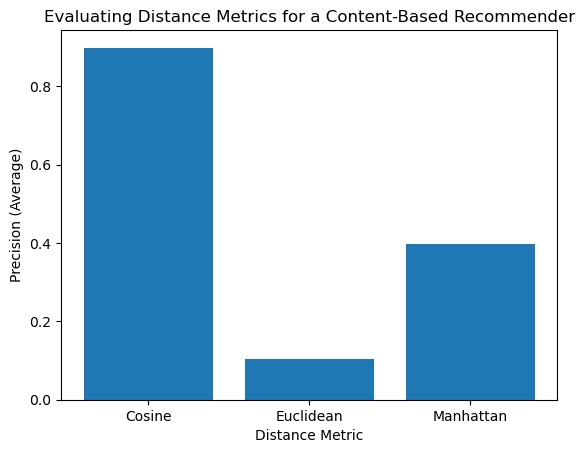

In [43]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

distance_metric_labels = ['Cosine', 'Euclidean', 'Manhattan']
distance_evaluations = [cbf_cosine_eval['average_precision'], cbf_euclidean_eval['average_precision'], cbf_manhattan_eval['average_precision']]

ax.bar(distance_metric_labels, distance_evaluations)
ax.set_ylabel('Precision (Average)')
ax.set_xlabel('Distance Metric')
ax.set_title('Evaluating Distance Metrics for a Content-Based Recommender')

plt.show()

## Evaluate the Collaborative Recommender

### Use the Standard Dataset

In [44]:
cf_ratings_data = convert_user_ratings_to_surprise_dataset(train_df)
cf_svd_recommender = CollaborativeFilteringRecommender(cf_ratings_data, performGridsearch=False)

In [45]:
cf_svd_recommendations = cf_svd_recommender.test_recommendations(num_recommendations, test_df, std_anime_cbf_recommender.anime_vector_df, evaluation_distance_metric=eval_dist_metric)
cf_svd_recommendations

Num Users Not Scored: 0


{'average_precision': 0.5784674379305857}

In [46]:
cf_nmf_recommender = CollaborativeFilteringRecommender(cf_ratings_data, mf_algorithm=NMF, performGridsearch=False)

In [47]:
cf_nmf_recommendations = cf_nmf_recommender.test_recommendations(num_recommendations, test_df, std_anime_cbf_recommender.anime_vector_df, evaluation_distance_metric=eval_dist_metric)
cf_nmf_recommendations

Num Users Not Scored: 0


{'average_precision': 0.4486156245937861}

### Use the New Users Dataset

In [48]:
new_cf_ratings_data = convert_user_ratings_to_surprise_dataset(new_users_train_df)
new_cf_svd_recommender = CollaborativeFilteringRecommender(new_cf_ratings_data, performGridsearch=False)

In [49]:
new_cf_svd_recommendations = new_cf_svd_recommender.test_recommendations(num_recommendations, new_users_test_df, std_anime_cbf_recommender.anime_vector_df, evaluation_distance_metric=eval_dist_metric)
new_cf_svd_recommendations

Num Users Not Scored: 0


{'average_precision': 0.43754210709722524}

In [50]:
new_cf_nmf_recommender = CollaborativeFilteringRecommender(new_cf_ratings_data, mf_algorithm=NMF, performGridsearch=False)

In [51]:
new_cf_nmf_recommendations = new_cf_nmf_recommender.test_recommendations(num_recommendations, new_users_test_df, std_anime_cbf_recommender.anime_vector_df, evaluation_distance_metric=eval_dist_metric)
new_cf_nmf_recommendations

Num Users Not Scored: 0


{'average_precision': 0.2619409919851304}

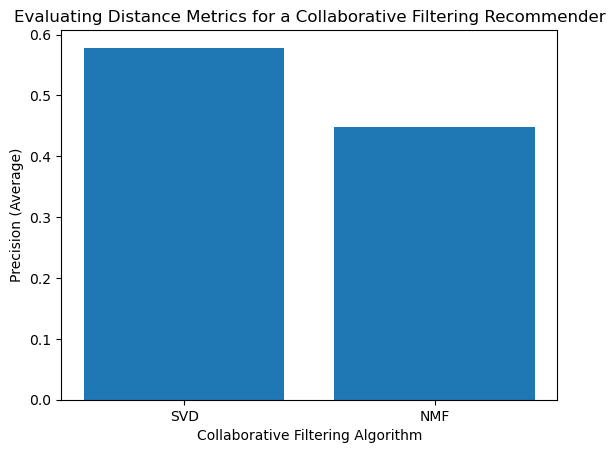

In [52]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

distance_metric_labels = ['SVD', 'NMF']
distance_evaluations = [cf_svd_recommendations['average_precision'], cf_nmf_recommendations['average_precision']]

ax.bar(distance_metric_labels, distance_evaluations)
ax.set_ylabel('Precision (Average)')
ax.set_xlabel('Collaborative Filtering Algorithm')
ax.set_title('Evaluating Distance Metrics for a Collaborative Filtering Recommender')

plt.show()

## Evaluate the Hybrid Recommender

In [53]:
hybrid_recommender = HybridRecommender(anime_df, train_df)

In [54]:
hybrid_recommender_eval = hybrid_recommender.test_recommendations(num_recommendations, test_df, std_anime_cbf_recommender.anime_vector_df, evaluation_distance_metric=eval_dist_metric)
hybrid_recommender_eval

Num Users Not Scored: 0


{'average_precision': 0.8198882100610743}

In [55]:
new_hybrid_recommender = HybridRecommender(anime_df, new_users_train_df)

In [56]:
new_hybrid_recommender_eval = new_hybrid_recommender.test_recommendations(num_recommendations, new_users_test_df, std_anime_cbf_recommender.anime_vector_df, evaluation_distance_metric=eval_dist_metric)
new_hybrid_recommender_eval

Num Users Not Scored: 0


{'average_precision': 0.6413230340341451}

## Compare the Recommenders

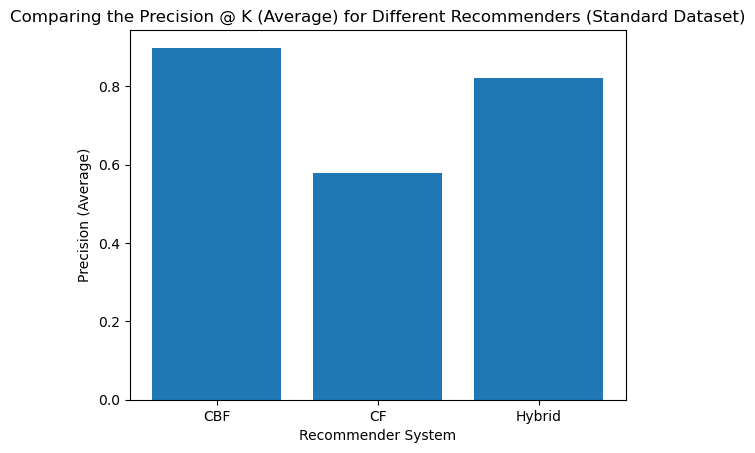

In [63]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

recommender_labels = ['CBF', 'CF', 'Hybrid']
distance_evaluations = [cbf_cosine_eval['average_precision'], cf_svd_recommendations['average_precision'], hybrid_recommender_eval['average_precision']]

ax.bar(recommender_labels, distance_evaluations)
ax.set_ylabel('Precision (Average)')
ax.set_xlabel('Recommender System')
ax.set_title('Comparing the Precision @ K (Average) for Different Recommenders (Standard Dataset)')

plt.show()

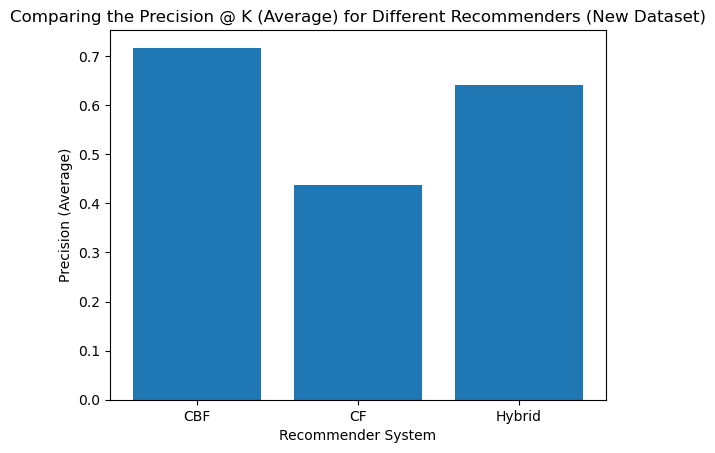

In [62]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

recommender_labels = ['CBF', 'CF', 'Hybrid']
distance_evaluations = [new_cbf_cosine_eval['average_precision'], new_cf_svd_recommendations['average_precision'], new_hybrid_recommender_eval['average_precision']]

ax.bar(recommender_labels, distance_evaluations)
ax.set_ylabel('Precision (Average)')
ax.set_xlabel('Recommender System')
ax.set_title('Comparing the Precision @ K (Average) for Different Recommenders (New Dataset)')

plt.show()

# Save the Recommenders
Finally, save the recommenders so they can be used with Streamlit.

In [66]:
import pickle

def write_recommender(recommender_inst, file_name):
    with open(file_name, "wb") as fp:
        pickle.dump(recommender_inst, fp)

In [67]:
# Hybrid
write_recommender(hybrid_recommender, "data/hybrid_recommender")
write_recommender(new_hybrid_recommender, "data/new_hybrid_recommender")

# Collaborative
write_recommender(cf_svd_recommender, "data/collaborative_recommender")
write_recommender(new_cf_svd_recommender, "data/new_collaborative_recommender")

# Content-Based
write_recommender(std_anime_cbf_recommender, "data/cbf_recommender")
write_recommender(new_anime_cbf_recommender, "data/new_cbf_recommender")

## Test Opening One of The Recommender Files

In [71]:
cbf_recommender_file = open('data/cbf_recommender', 'rb')
cbf_recommender = pickle.load(cbf_recommender_file)

In [73]:
recommendations = cbf_recommender.recommend_user(10, 5, add_anime_info=True)
recommendations

,distance,id,title,start_date,end_date,synopsis,score,rank,popularity,num_list_users,...,status,genres,num_episodes,start_season,broadcast_day,broadcast_time,source,rating,studios,combined
0,0.202754,39988,Isekai Quartet 2,2020-01-15,2020-04-01,Despite completing all the tasks given to them...,7.36,2334.0,1004,228988,...,finished_airing,"Comedy,Fantasy,Isekai,Parody",12,winter,wednesday,00:30,original,pg_13,Studio PuYUKAI,"Comedy,Fantasy,Isekai,Parody Despite completin..."
1,0.211941,40496,Maou Gakuin no Futekigousha: Shijou Saikyou no...,2020-07-04,2020-09-26,"In the distant past, a war between humans and ...",7.37,2283.0,240,762128,...,finished_airing,"Action,Fantasy,Mythology,Reincarnation,School",13,summer,saturday,23:30,light_novel,r,SILVER LINK.,"Action,Fantasy,Mythology,Reincarnation,School ..."
2,0.221642,52211,Mashle,2023-04-08,2023-07-01,"In this magical world, one is easily identifie...",7.56,1578.0,570,387218,...,finished_airing,"Action,Comedy,Fantasy,Gag Humor,Parody,School,...",12,spring,saturday,00:00,manga,pg_13,A-1 Pictures,"Action,Comedy,Fantasy,Gag Humor,Parody,School,..."
3,0.229340,10033,Toriko,2011-04-03,2014-03-30,Hamburgers that grow out of the ground like fo...,7.52,1708.0,1681,126583,...,finished_airing,"Action,Adventure,Comedy,Fantasy,Gourmet,Shounen",147,spring,sunday,09:00,manga,pg_13,Toei Animation,"Action,Adventure,Comedy,Fantasy,Gourmet,Shoune..."
4,0.233433,28755,Boruto: Naruto the Movie,2015-08-07,2015-08-07,"The spirited Boruto Uzumaki, son of Seventh Ho...",7.39,2191.0,471,455345,...,finished_airing,"Action,Adventure,Fantasy,Martial Arts,Shounen",1,summer,NaN,NaN,manga,pg_13,Pierrot,"Action,Adventure,Fantasy,Martial Arts,Shounen ..."
